In [1]:
import numpy as np
import tensorflow as tf
import keras
from tqdm import tqdm
import keras.backend as K

import os, sys
import time
from datetime import datetime

import matplotlib.pyplot as plt

In [2]:
sys.path.append('..')

In [3]:
ENVIRON = 'snuh'
np.random.seed(1)

dim_HT1D = (6000,1) if ENVIRON == 'snuh' else (3000,1)
n_classes = 5 if ENVIRON == 'snuh' else 6
epochs = 30
bs = 64
BASE_LEARNING_RATE = 1e-3

import nets
from Data import datagen
import importlib 
importlib.reload(nets)

model = nets.VAE(256)


In [4]:
x = np.random.random((1,) + dim_HT1D)
x = tf.convert_to_tensor(x)
print(model(x))
print(model.name)
print(model.summary())

UnimplementedError: Exception encountered when calling layer "conv1d" (type Conv1D).

DNN library is not found. [Op:Conv2D]

Call arguments received:
  • inputs=tf.Tensor(shape=(1, 6000, 1), dtype=float32)

In [4]:
def match_annotations_npy(dirname, filepath):
    filename = os.path.basename(filepath)
    if ENVIRON == 'snuh':
        search_filename = filename.split('.')[0]
    else:
        search_filename = filename.split('-')[0][:-2]
        
    file_list = os.listdir(dirname)
    filenames = [f for f in file_list if search_filename in f if f.endswith('.npy')]
    return filenames

In [42]:
if ENVIRON == 'snuh':
    PROCESSED_DATA_PATH = os.path.join('/tf','00_data')
    save_signals_path = os.path.join(PROCESSED_DATA_PATH,'signals_filtered')
    save_annotations_path = os.path.join(PROCESSED_DATA_PATH,'sleep_edf','all_channels','annotations')
    list_files = [os.path.join(save_signals_path, f) for f in os.listdir(save_signals_path) if f.endswith('.npy')]
    train_test_split = 0.7
    split_cnt = int(train_test_split * len(list_files))

    list_files_train = []
    list_files_test = []

    list_ann_files_train = []
    list_ann_files_test = []

    list_files_train = np.random.choice(list_files[:split_cnt], int(float(1) * split_cnt), replace=False)
    list_files_train = list_files_train.tolist()
    for f in list_files_train:
        ann_file = match_annotations_npy(save_annotations_path, f)
        list_ann_files_train.append(os.path.join(save_annotations_path, ann_file[0]))

    list_files_test += list_files[split_cnt:]

    for f in list_files[split_cnt:]:
        ann_file = match_annotations_npy(save_annotations_path, f)
        list_ann_files_test.append(os.path.join(save_annotations_path, ann_file[0]))

else:
    PROCESSED_DATA_PATH = os.path.join('/home','aiot','data','origin_npy')
    save_signals_path_SC = os.path.join(PROCESSED_DATA_PATH,'signals_SC_filtered')
    save_annotations_path_SC = os.path.join(PROCESSED_DATA_PATH,'annotations_SC')
    save_signals_path_ST = os.path.join(PROCESSED_DATA_PATH,'signals_ST_filtered')
    save_annotations_path_ST = os.path.join(PROCESSED_DATA_PATH,'annotations_ST')

    list_files_SC = [os.path.join(save_signals_path_SC, f) for f in os.listdir(save_signals_path_SC) if f.endswith('.npy')]
    list_files_ST = [os.path.join(save_signals_path_ST, f) for f in os.listdir(save_signals_path_ST) if f.endswith('.npy')]

    train_test_split = 0.7
    split_cnt_SC = int(train_test_split * len(list_files_SC))
    split_cnt_ST = int(train_test_split * len(list_files_ST))

    SC_ST = [x for x in FLAGS.include_type.split(',')]
    include_SC = 'SC' in SC_ST
    include_ST = 'ST' in SC_ST

    list_files_train = []
    list_files_test = []

    list_ann_files_train = []
    list_ann_files_test = []

    if include_SC:
        list_files_SC_train = np.random.choice(list_files_SC[:split_cnt_SC], int(float(1) * split_cnt_SC), replace=False)
        list_files_train += list_files_SC_train.tolist()
        for f in list_files_SC_train:
            ann_file = match_annotations_npy(save_annotations_path_SC, f)
            list_ann_files_train.append(os.path.join(save_annotations_path_SC, ann_file[0]))

        list_files_test += list_files_SC[split_cnt_SC:]

        for f in list_files_SC[split_cnt_SC:]:
            ann_file = match_annotations_npy(save_annotations_path_SC, f)
            list_ann_files_test.append(os.path.join(save_annotations_path_SC, ann_file[0]))

    if include_ST:
        list_files_ST_train = np.random.choice(list_files_ST[:split_cnt_ST], int(float(FLAGS.data_ratio) * split_cnt_ST), replace=False)
        list_files_train += list_files_ST_train.tolist()
        for f in list_files_ST_train:
            ann_file = match_annotations_npy(save_annotations_path_ST, f)
            list_ann_files_train.append(os.path.join(save_annotations_path_ST, ann_file[0]))

        list_files_test += list_files_ST[split_cnt_ST:]
        for f in list_files_ST[split_cnt_ST:]:
            ann_file = match_annotations_npy(save_annotations_path_ST, f)
            list_ann_files_test.append(os.path.join(save_annotations_path_ST, ann_file[0]))

In [43]:
train_generator = datagen.DataGenerator(list_files_train, list_ann_files_train, 
                          batch_size=bs, dim=dim_HT1D, n_classes=n_classes, shuffle=True, balanced_sampling=False)
test_generator = datagen.DataGenerator(list_files_test, list_ann_files_test, 
                          batch_size=bs, dim=dim_HT1D, n_classes=n_classes, shuffle=False, balanced_sampling=False)

/tf/00_data/signals_filtered/A2018-EM-01-0194.npy
/tf/00_data/sleep_edf/all_channels/annotations/A2018-EM-01-0194_ann.npy
/tf/00_data/signals_filtered/A2018-EM-01-0194.npy
/tf/00_data/sleep_edf/all_channels/annotations/A2018-EM-01-0194_ann.npy
/tf/00_data/signals_filtered/A2018-EM-01-0194.npy
/tf/00_data/sleep_edf/all_channels/annotations/A2018-EM-01-0194_ann.npy
/tf/00_data/signals_filtered/A2018-EM-01-0194.npy
/tf/00_data/sleep_edf/all_channels/annotations/A2018-EM-01-0194_ann.npy
/tf/00_data/signals_filtered/A2018-EM-01-0194.npy
/tf/00_data/sleep_edf/all_channels/annotations/A2018-EM-01-0194_ann.npy
/tf/00_data/signals_filtered/A2018-EM-01-0194.npy
/tf/00_data/sleep_edf/all_channels/annotations/A2018-EM-01-0194_ann.npy
/tf/00_data/signals_filtered/A2018-EM-01-0194.npy
/tf/00_data/sleep_edf/all_channels/annotations/A2018-EM-01-0194_ann.npy
/tf/00_data/signals_filtered/A2018-EM-01-0194.npy
/tf/00_data/sleep_edf/all_channels/annotations/A2018-EM-01-0194_ann.npy
/tf/00_data/signals_filt

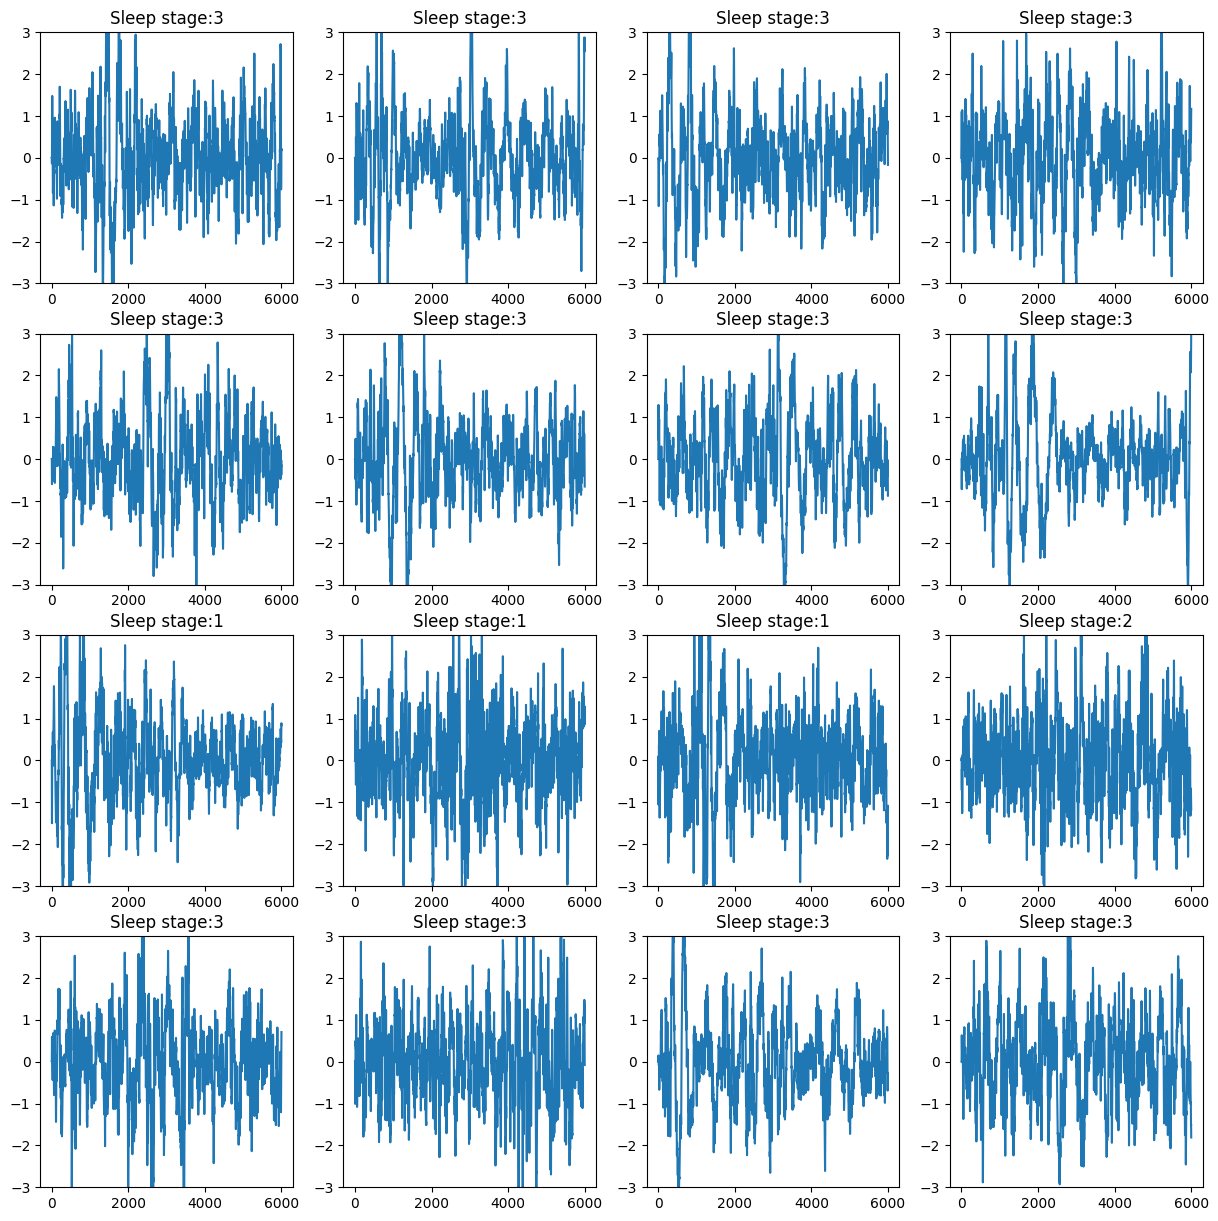

In [44]:
# Check sample data
fig = plt.figure(figsize=(15,15))
for idx, (x, y) in enumerate(test_generator):
    if idx <= 31: continue
    for i in range(16):
        plt.subplot(4,4, i+1)
        plt.plot(x[i])
        plt.ylim((-3,3))
        plt.title("Sleep stage:" + str(y[i]))
    plt.show()
    break




/tf/00_data/signals_filtered_uniScale/A2018-EM-01-0194.npy
/tf/00_data/sleep_edf/all_channels/annotations/A2018-EM-01-0194_ann.npy
/tf/00_data/signals_filtered_uniScale/A2018-EM-01-0194.npy
/tf/00_data/sleep_edf/all_channels/annotations/A2018-EM-01-0194_ann.npy
/tf/00_data/signals_filtered_uniScale/A2018-EM-01-0194.npy
/tf/00_data/sleep_edf/all_channels/annotations/A2018-EM-01-0194_ann.npy
/tf/00_data/signals_filtered_uniScale/A2018-EM-01-0194.npy
/tf/00_data/sleep_edf/all_channels/annotations/A2018-EM-01-0194_ann.npy
/tf/00_data/signals_filtered_uniScale/A2018-EM-01-0194.npy
/tf/00_data/sleep_edf/all_channels/annotations/A2018-EM-01-0194_ann.npy
/tf/00_data/signals_filtered_uniScale/A2018-EM-01-0194.npy
/tf/00_data/sleep_edf/all_channels/annotations/A2018-EM-01-0194_ann.npy
/tf/00_data/signals_filtered_uniScale/A2018-EM-01-0194.npy
/tf/00_data/sleep_edf/all_channels/annotations/A2018-EM-01-0194_ann.npy
/tf/00_data/signals_filtered_uniScale/A2018-EM-01-0194.npy
/tf/00_data/sleep_edf/al

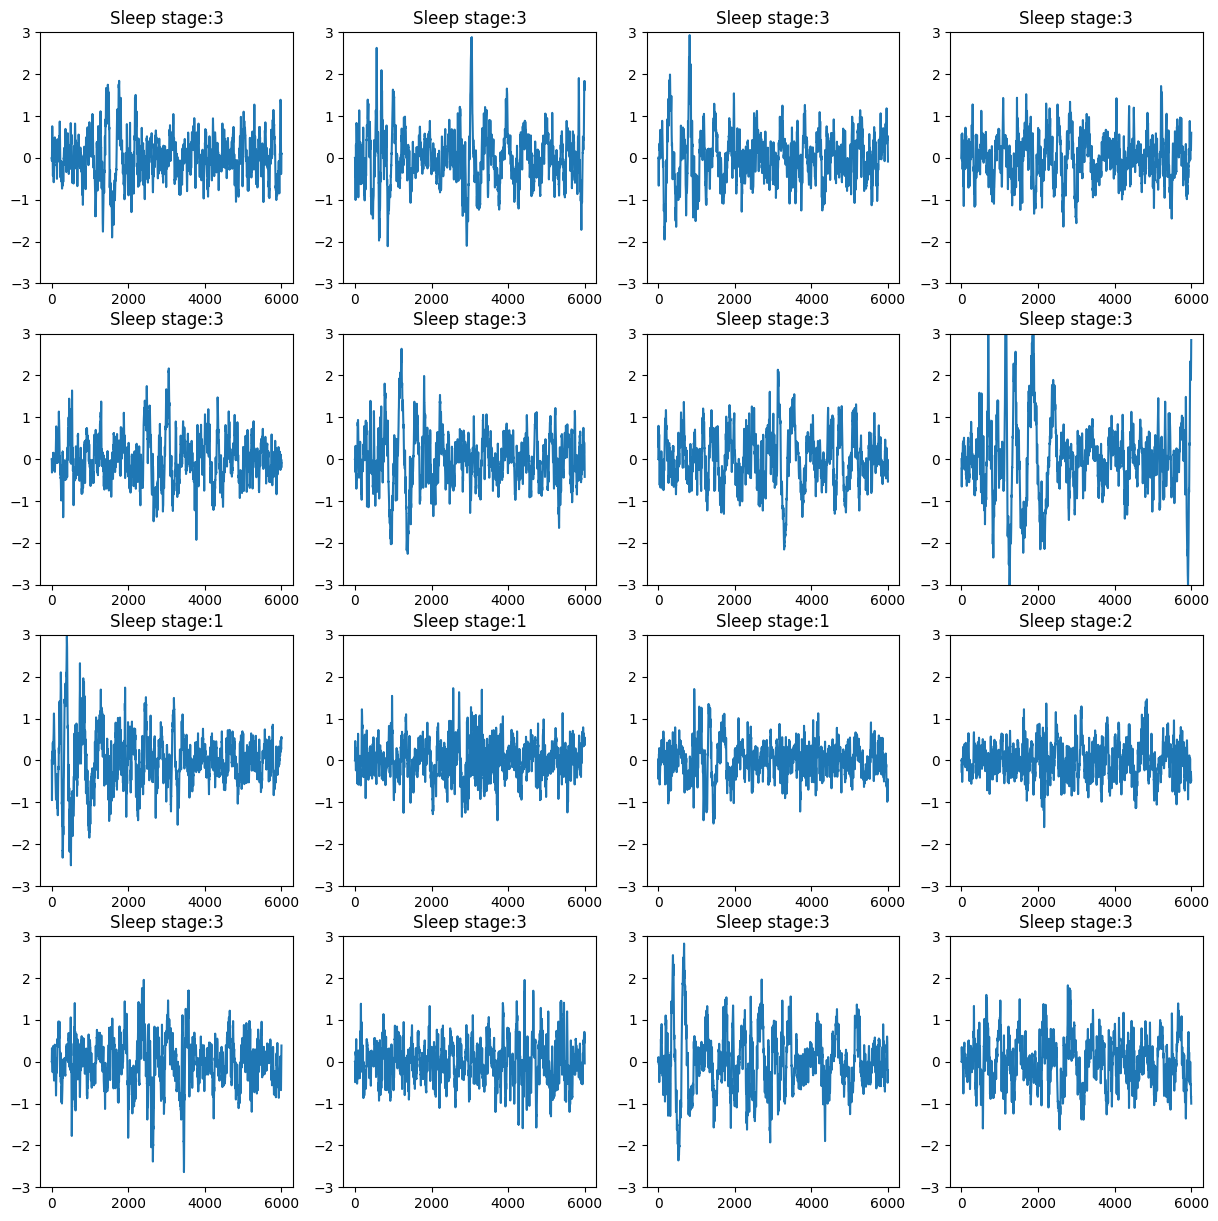

In [41]:
# Check sample data
fig = plt.figure(figsize=(15,15))
for idx, (x, y) in enumerate(test_generator):
    if idx <= 31: continue
    for i in range(16):
        plt.subplot(4,4, i+1)
        plt.plot(x[i])
        plt.ylim((-3,3))
        plt.title("Sleep stage:" + str(y[i]))
    plt.show()
    break

In [8]:
def get_current_lr(epoch):
    lr = BASE_LEARNING_RATE
    for _ in range(epoch // 10):
        lr *= 0.1
    lr = max(lr, 1e-6)
    return lr

def adjust_learning_rate(optimizer, epoch):
    lr = get_current_lr(epoch)
    optimizer.learning_rate = lr

LOG_DIR = './logs'
os.makedirs(LOG_DIR, exist_ok=True)

startTime = datetime.now()
log_fname = startTime.strftime("%Y%m%d %H%M")
LOG_FOUT = open(os.path.join(LOG_DIR, 'vae_' + model.name + '_' + log_fname + '.txt'), 'a')
#LOG_FOUT.write(str(FLAGS)+'\n')
def log_string(out_str):
    LOG_FOUT.write(out_str+'\n')
    LOG_FOUT.flush()
    print(out_str)

In [27]:
def compute_loss(data, reconstruction, mu, log_var, alpha = 1):    
    # Reconstruction loss-
    print(data - reconstruction)
    recon_loss = tf.reduce_sum(tf.math.square (data - reconstruction), axis=1)
    '''
    # KL-divergence loss-    
    kl_loss = -0.5 * (1 + log_var - tf.square(mu) - tf.exp(log_var))
    kl_loss = tf.reduce_sum(
            kl_loss,
            axis = 1
        )        
    total_loss = (recon_loss * alpha) + kl_loss
    '''
    kl_loss = 0
    total_loss = recon_loss
    print("Total loss", total_loss)
    
    return total_loss, recon_loss, kl_loss

In [28]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
ckpt = tf.train.Checkpoint(step=tf.Variable(0), optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(ckpt, '.tf_ckpt/ckpt_' + model.name, max_to_keep=1)
start_epoch = 0
# if manager.latest_checkpoint:
#    ckpt.restore(manager.latest_checkpoint)
#    start_epoch = ckpt.step.numpy()-1
best_test_loss = 1e+6

In [29]:
@tf.function
def train_step(data):
    with tf.GradientTape() as tape:
        #data_recon, mu, log_var = model(data, training=True)
        data_recon = model(data, training=True)        
        #total_loss, recon_loss, kl_loss = compute_loss(data=data, reconstruction = data_recon, mu = mu, log_var = log_var, alpha=10)
        total_loss, recon_loss, kl_loss = compute_loss(data=data, reconstruction = data_recon, mu = 0, log_var = 0, alpha=10)
        print(total_loss, recon_loss)
    grads = tape.gradient(tf.reduce_mean(total_loss), model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))    
    return total_loss, recon_loss, kl_loss

@tf.function
def test_step(data):
    #data_recon, mu, log_var = model(data, training=True)
    #total_loss, recon_loss, kl_loss = compute_loss(data=data, reconstruction = data_recon, mu = mu, log_var = log_var)
    data_recon = model(data, training=True)
    total_loss, recon_loss, kl_loss = compute_loss(data=data, reconstruction = data_recon, mu = 0, log_var = 0)
    return total_loss, recon_loss, kl_loss

In [30]:
model.summary()

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d__encoder (Conv1D_Enc  multiple                 2299584   
 oder)                                                           
                                                                 
 conv1d__decoder (Conv1D_Dec  multiple                 703407    
 oder)                                                           
                                                                 
Total params: 3,002,991
Trainable params: 2,996,415
Non-trainable params: 6,576
_________________________________________________________________


In [31]:
best_test_loss = 1e+7

In [32]:
for e in range(start_epoch, 50):    
    total_cnt, total_loss, recon_loss, kl_loss = 0.0, 0.0, 0.0, 0.0
    log_string('-'*20 + 'Epoch ' + str(e) + '-'*20)
    adjust_learning_rate(optimizer, e)
    start = time.time()
    for idx, (x, y) in enumerate(train_generator):   
        train_total_loss, train_recon_loss, train_kl_loss = train_step(x)
        total_cnt += y.shape[0]        
        total_loss += tf.reduce_sum(train_total_loss)
        recon_loss += tf.reduce_sum(train_recon_loss)
        kl_loss += tf.reduce_sum(train_kl_loss)
        if (idx + 1) % 10 == 0 or idx+1 == len(train_generator):
            print("[%d / %d] Training total loss: %.6f, recon_loss: %.6f, kl_loss: %.6f"%
                  (idx+1, len(train_generator), total_loss / total_cnt, recon_loss / total_cnt, kl_loss / total_cnt), end='\r', flush=True)        
        
    print("")
    log_string("Training total loss: %.6f, recon_loss: %.6f, kl_loss: %.6f"%
    (total_loss / total_cnt, recon_loss / total_cnt, kl_loss / total_cnt))
    log_string("Training time: %.2f sec "%(time.time() - start))
    
    
    if (e+1 >= 10 and (e+1) % 5 == 0) or e == 0:
    #if e % 3 == 0:
        start = time.time()
        
        total_cnt, total_loss, recon_loss, kl_loss = 0.0, 0.0, 0.0, 0.0
        for idx, (x, y) in enumerate(test_generator):            
            val_total_loss, val_recon_loss, val_kl_loss = test_step(x)            
            total_cnt += y.shape[0]
            total_loss += tf.reduce_sum(val_total_loss)
            recon_loss += tf.reduce_sum(val_recon_loss)
            kl_loss += tf.reduce_sum(val_kl_loss)
            if (idx + 1) % 10 == 0 or idx+1 == len(test_generator):
                print("[%d / %d] test total loss: %.6f, recon loss : %.6f, kl loss : %.6f"%
                    (idx+1, len(test_generator), total_loss / total_cnt, recon_loss / total_cnt, kl_loss / total_cnt),end='\r', flush=True)
            
        print("")
        log_string("test total loss: %.6f, recon loss : %.6f, kl loss : %.6f"%(total_loss / total_cnt, recon_loss / total_cnt, kl_loss / total_cnt))
        log_string("Eval time: %.2f sec"%(time.time() - start))
        
        if best_test_loss > total_loss / total_cnt:
            best_test_loss = total_loss / total_cnt
            save_path = manager.save(checkpoint_number=ckpt.step)
            print("Saved checkpoint for step {}: {}".format(int(ckpt.step), save_path))   

    ckpt.step.assign_add(1)

LOG_FOUT.close()

--------------------Epoch 0--------------------
Tensor("sub:0", shape=(64, 6000, 1), dtype=float32)
Total loss Tensor("Sum:0", shape=(64, 1), dtype=float32)
Tensor("Sum:0", shape=(64, 1), dtype=float32) Tensor("Sum:0", shape=(64, 1), dtype=float32)


ValueError: in user code:

    File "<ipython-input-11-5be188fd9a75>", line 10, in train_step  *
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
    File "/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/optimizer_v2.py", line 633, in apply_gradients  **
        grads_and_vars = optimizer_utils.filter_empty_gradients(grads_and_vars)
    File "/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/utils.py", line 73, in filter_empty_gradients
        raise ValueError(f"No gradients provided for any variable: {variable}. "

    ValueError: No gradients provided for any variable: (['vae/conv1d__encoder/conv1d_block/conv1d/kernel:0', 'vae/conv1d__encoder/conv1d_block/conv1d/bias:0', 'vae/conv1d__encoder/conv1d_block/batch_normalization/gamma:0', 'vae/conv1d__encoder/conv1d_block/batch_normalization/beta:0', 'vae/conv1d__encoder/conv1d_block_1/conv1d_1/kernel:0', 'vae/conv1d__encoder/conv1d_block_1/conv1d_1/bias:0', 'vae/conv1d__encoder/conv1d_block_1/batch_normalization_1/gamma:0', 'vae/conv1d__encoder/conv1d_block_1/batch_normalization_1/beta:0', 'vae/conv1d__encoder/conv1d_block_2/conv1d_2/kernel:0', 'vae/conv1d__encoder/conv1d_block_2/conv1d_2/bias:0', 'vae/conv1d__encoder/conv1d_block_2/batch_normalization_2/gamma:0', 'vae/conv1d__encoder/conv1d_block_2/batch_normalization_2/beta:0', 'vae/conv1d__encoder/conv1d_block_3/conv1d_3/kernel:0', 'vae/conv1d__encoder/conv1d_block_3/conv1d_3/bias:0', 'vae/conv1d__encoder/conv1d_block_3/batch_normalization_3/gamma:0', 'vae/conv1d__encoder/conv1d_block_3/batch_normalization_3/beta:0', 'vae/conv1d__encoder/conv1d_block_4/conv1d_4/kernel:0', 'vae/conv1d__encoder/conv1d_block_4/conv1d_4/bias:0', 'vae/conv1d__encoder/conv1d_block_4/batch_normalization_4/gamma:0', 'vae/conv1d__encoder/conv1d_block_4/batch_normalization_4/beta:0', 'vae/conv1d__encoder/conv1d_block_5/conv1d_5/kernel:0', 'vae/conv1d__encoder/conv1d_block_5/conv1d_5/bias:0', 'vae/conv1d__encoder/conv1d_block_5/batch_normalization_5/gamma:0', 'vae/conv1d__encoder/conv1d_block_5/batch_normalization_5/beta:0', 'vae/conv1d__encoder/conv1d_block_6/conv1d_6/kernel:0', 'vae/conv1d__encoder/conv1d_block_6/conv1d_6/bias:0', 'vae/conv1d__encoder/conv1d_block_6/batch_normalization_6/gamma:0', 'vae/conv1d__encoder/conv1d_block_6/batch_normalization_6/beta:0', 'vae/conv1d__encoder/conv1d_block_7/conv1d_7/kernel:0', 'vae/conv1d__encoder/conv1d_block_7/conv1d_7/bias:0', 'vae/conv1d__encoder/conv1d_block_7/batch_normalization_7/gamma:0', 'vae/conv1d__encoder/conv1d_block_7/batch_normalization_7/beta:0', 'vae/conv1d__encoder/conv1d_block_9/conv1d_9/kernel:0', 'vae/conv1d__encoder/conv1d_block_9/conv1d_9/bias:0', 'vae/conv1d__encoder/conv1d_block_9/batch_normalization_9/gamma:0', 'vae/conv1d__encoder/conv1d_block_9/batch_normalization_9/beta:0', 'vae/conv1d__encoder/multihead_attention__feat/dense/kernel:0', 'vae/conv1d__encoder/multihead_attention__feat/dense/bias:0', 'vae/conv1d__encoder/conv1d_10/kernel:0', 'vae/conv1d__encoder/conv1d_10/bias:0', 'vae/conv1d__encoder/batch_normalization_10/gamma:0', 'vae/conv1d__encoder/batch_normalization_10/beta:0', 'vae/conv1d__encoder/conv1d_block_10/conv1d_11/kernel:0', 'vae/conv1d__encoder/conv1d_block_10/conv1d_11/bias:0', 'vae/conv1d__encoder/conv1d_block_10/batch_normalization_11/gamma:0', 'vae/conv1d__encoder/conv1d_block_10/batch_normalization_11/beta:0', 'vae/conv1d__encoder/conv1d_block_11/conv1d_12/kernel:0', 'vae/conv1d__encoder/conv1d_block_11/conv1d_12/bias:0', 'vae/conv1d__encoder/conv1d_block_11/batch_normalization_12/gamma:0', 'vae/conv1d__encoder/conv1d_block_11/batch_normalization_12/beta:0', 'vae/conv1d__encoder/dense_1/kernel:0', 'vae/conv1d__encoder/dense_1/bias:0', 'vae/conv1d__encoder/batch_normalization_13/gamma:0', 'vae/conv1d__encoder/batch_normalization_13/beta:0', 'vae/conv1d__encoder/dense_2/kernel:0', 'vae/conv1d__encoder/dense_2/bias:0', 'vae/conv1d__encoder/batch_normalization_14/gamma:0', 'vae/conv1d__encoder/batch_normalization_14/beta:0', 'vae/conv1d__decoder/dense_3/kernel:0', 'vae/conv1d__decoder/dense_3/bias:0', 'vae/conv1d__decoder/batch_normalization_15/gamma:0', 'vae/conv1d__decoder/batch_normalization_15/beta:0', 'vae/conv1d__decoder/dense_4/kernel:0', 'vae/conv1d__decoder/dense_4/bias:0', 'vae/conv1d__decoder/batch_normalization_16/gamma:0', 'vae/conv1d__decoder/batch_normalization_16/beta:0', 'vae/conv1d__decoder/dense_5/kernel:0', 'vae/conv1d__decoder/dense_5/bias:0', 'vae/conv1d__decoder/batch_normalization_17/gamma:0', 'vae/conv1d__decoder/batch_normalization_17/beta:0', 'vae/conv1d__decoder/conv1d_transpose/kernel:0', 'vae/conv1d__decoder/conv1d_transpose/bias:0', 'vae/conv1d__decoder/batch_normalization_18/gamma:0', 'vae/conv1d__decoder/batch_normalization_18/beta:0', 'vae/conv1d__decoder/conv1d_transpose_1/kernel:0', 'vae/conv1d__decoder/conv1d_transpose_1/bias:0', 'vae/conv1d__decoder/batch_normalization_19/gamma:0', 'vae/conv1d__decoder/batch_normalization_19/beta:0', 'vae/conv1d__decoder/conv1d_transpose_2/kernel:0', 'vae/conv1d__decoder/conv1d_transpose_2/bias:0', 'vae/conv1d__decoder/batch_normalization_20/gamma:0', 'vae/conv1d__decoder/batch_normalization_20/beta:0', 'vae/conv1d__decoder/conv1d_transpose_3/kernel:0', 'vae/conv1d__decoder/conv1d_transpose_3/bias:0', 'vae/conv1d__decoder/batch_normalization_21/gamma:0', 'vae/conv1d__decoder/batch_normalization_21/beta:0', 'vae/conv1d__decoder/conv1d_transpose_4/kernel:0', 'vae/conv1d__decoder/conv1d_transpose_4/bias:0', 'vae/conv1d__decoder/batch_normalization_22/gamma:0', 'vae/conv1d__decoder/batch_normalization_22/beta:0', 'vae/conv1d__decoder/conv1d_transpose_5/kernel:0', 'vae/conv1d__decoder/conv1d_transpose_5/bias:0', 'vae/conv1d__decoder/batch_normalization_23/gamma:0', 'vae/conv1d__decoder/batch_normalization_23/beta:0', 'vae/conv1d__decoder/conv1d_transpose_6/kernel:0', 'vae/conv1d__decoder/conv1d_transpose_6/bias:0'],). Provided `grads_and_vars` is ((None, <tf.Variable 'vae/conv1d__encoder/conv1d_block/conv1d/kernel:0' shape=(5, 1, 32) dtype=float32>), (None, <tf.Variable 'vae/conv1d__encoder/conv1d_block/conv1d/bias:0' shape=(32,) dtype=float32>), (None, <tf.Variable 'vae/conv1d__encoder/conv1d_block/batch_normalization/gamma:0' shape=(32,) dtype=float32>), (None, <tf.Variable 'vae/conv1d__encoder/conv1d_block/batch_normalization/beta:0' shape=(32,) dtype=float32>), (None, <tf.Variable 'vae/conv1d__encoder/conv1d_block_1/conv1d_1/kernel:0' shape=(5, 32, 64) dtype=float32>), (None, <tf.Variable 'vae/conv1d__encoder/conv1d_block_1/conv1d_1/bias:0' shape=(64,) dtype=float32>), (None, <tf.Variable 'vae/conv1d__encoder/conv1d_block_1/batch_normalization_1/gamma:0' shape=(64,) dtype=float32>), (None, <tf.Variable 'vae/conv1d__encoder/conv1d_block_1/batch_normalization_1/beta:0' shape=(64,) dtype=float32>), (None, <tf.Variable 'vae/conv1d__encoder/conv1d_block_2/conv1d_2/kernel:0' shape=(5, 64, 64) dtype=float32>), (None, <tf.Variable 'vae/conv1d__encoder/conv1d_block_2/conv1d_2/bias:0' shape=(64,) dtype=float32>), (None, <tf.Variable 'vae/conv1d__encoder/conv1d_block_2/batch_normalization_2/gamma:0' shape=(64,) dtype=float32>), (None, <tf.Variable 'vae/conv1d__encoder/conv1d_block_2/batch_normalization_2/beta:0' shape=(64,) dtype=float32>), (None, <tf.Variable 'vae/conv1d__encoder/conv1d_block_3/conv1d_3/kernel:0' shape=(10, 64, 64) dtype=float32>), (None, <tf.Variable 'vae/conv1d__encoder/conv1d_block_3/conv1d_3/bias:0' shape=(64,) dtype=float32>), (None, <tf.Variable 'vae/conv1d__encoder/conv1d_block_3/batch_normalization_3/gamma:0' shape=(64,) dtype=float32>), (None, <tf.Variable 'vae/conv1d__encoder/conv1d_block_3/batch_normalization_3/beta:0' shape=(64,) dtype=float32>), (None, <tf.Variable 'vae/conv1d__encoder/conv1d_block_4/conv1d_4/kernel:0' shape=(10, 64, 64) dtype=float32>), (None, <tf.Variable 'vae/conv1d__encoder/conv1d_block_4/conv1d_4/bias:0' shape=(64,) dtype=float32>), (None, <tf.Variable 'vae/conv1d__encoder/conv1d_block_4/batch_normalization_4/gamma:0' shape=(64,) dtype=float32>), (None, <tf.Variable 'vae/conv1d__encoder/conv1d_block_4/batch_normalization_4/beta:0' shape=(64,) dtype=float32>), (None, <tf.Variable 'vae/conv1d__encoder/conv1d_block_5/conv1d_5/kernel:0' shape=(10, 64, 64) dtype=float32>), (None, <tf.Variable 'vae/conv1d__encoder/conv1d_block_5/conv1d_5/bias:0' shape=(64,) dtype=float32>), (None, <tf.Variable 'vae/conv1d__encoder/conv1d_block_5/batch_normalization_5/gamma:0' shape=(64,) dtype=float32>), (None, <tf.Variable 'vae/conv1d__encoder/conv1d_block_5/batch_normalization_5/beta:0' shape=(64,) dtype=float32>), (None, <tf.Variable 'vae/conv1d__encoder/conv1d_block_6/conv1d_6/kernel:0' shape=(10, 64, 64) dtype=float32>), (None, <tf.Variable 'vae/conv1d__encoder/conv1d_block_6/conv1d_6/bias:0' shape=(64,) dtype=float32>), (None, <tf.Variable 'vae/conv1d__encoder/conv1d_block_6/batch_normalization_6/gamma:0' shape=(64,) dtype=float32>), (None, <tf.Variable 'vae/conv1d__encoder/conv1d_block_6/batch_normalization_6/beta:0' shape=(64,) dtype=float32>), (None, <tf.Variable 'vae/conv1d__encoder/conv1d_block_7/conv1d_7/kernel:0' shape=(10, 64, 64) dtype=float32>), (None, <tf.Variable 'vae/conv1d__encoder/conv1d_block_7/conv1d_7/bias:0' shape=(64,) dtype=float32>), (None, <tf.Variable 'vae/conv1d__encoder/conv1d_block_7/batch_normalization_7/gamma:0' shape=(64,) dtype=float32>), (None, <tf.Variable 'vae/conv1d__encoder/conv1d_block_7/batch_normalization_7/beta:0' shape=(64,) dtype=float32>), (None, <tf.Variable 'vae/conv1d__encoder/conv1d_block_9/conv1d_9/kernel:0' shape=(10, 64, 64) dtype=float32>), (None, <tf.Variable 'vae/conv1d__encoder/conv1d_block_9/conv1d_9/bias:0' shape=(64,) dtype=float32>), (None, <tf.Variable 'vae/conv1d__encoder/conv1d_block_9/batch_normalization_9/gamma:0' shape=(64,) dtype=float32>), (None, <tf.Variable 'vae/conv1d__encoder/conv1d_block_9/batch_normalization_9/beta:0' shape=(64,) dtype=float32>), (None, <tf.Variable 'vae/conv1d__encoder/multihead_attention__feat/dense/kernel:0' shape=(64, 192) dtype=float32>), (None, <tf.Variable 'vae/conv1d__encoder/multihead_attention__feat/dense/bias:0' shape=(192,) dtype=float32>), (None, <tf.Variable 'vae/conv1d__encoder/conv1d_10/kernel:0' shape=(1, 64, 64) dtype=float32>), (None, <tf.Variable 'vae/conv1d__encoder/conv1d_10/bias:0' shape=(64,) dtype=float32>), (None, <tf.Variable 'vae/conv1d__encoder/batch_normalization_10/gamma:0' shape=(64,) dtype=float32>), (None, <tf.Variable 'vae/conv1d__encoder/batch_normalization_10/beta:0' shape=(64,) dtype=float32>), (None, <tf.Variable 'vae/conv1d__encoder/conv1d_block_10/conv1d_11/kernel:0' shape=(10, 448, 64) dtype=float32>), (None, <tf.Variable 'vae/conv1d__encoder/conv1d_block_10/conv1d_11/bias:0' shape=(64,) dtype=float32>), (None, <tf.Variable 'vae/conv1d__encoder/conv1d_block_10/batch_normalization_11/gamma:0' shape=(64,) dtype=float32>), (None, <tf.Variable 'vae/conv1d__encoder/conv1d_block_10/batch_normalization_11/beta:0' shape=(64,) dtype=float32>), (None, <tf.Variable 'vae/conv1d__encoder/conv1d_block_11/conv1d_12/kernel:0' shape=(10, 64, 64) dtype=float32>), (None, <tf.Variable 'vae/conv1d__encoder/conv1d_block_11/conv1d_12/bias:0' shape=(64,) dtype=float32>), (None, <tf.Variable 'vae/conv1d__encoder/conv1d_block_11/batch_normalization_12/gamma:0' shape=(64,) dtype=float32>), (None, <tf.Variable 'vae/conv1d__encoder/conv1d_block_11/batch_normalization_12/beta:0' shape=(64,) dtype=float32>), (None, <tf.Variable 'vae/conv1d__encoder/dense_1/kernel:0' shape=(3008, 512) dtype=float32>), (None, <tf.Variable 'vae/conv1d__encoder/dense_1/bias:0' shape=(512,) dtype=float32>), (None, <tf.Variable 'vae/conv1d__encoder/batch_normalization_13/gamma:0' shape=(512,) dtype=float32>), (None, <tf.Variable 'vae/conv1d__encoder/batch_normalization_13/beta:0' shape=(512,) dtype=float32>), (None, <tf.Variable 'vae/conv1d__encoder/dense_2/kernel:0' shape=(512, 256) dtype=float32>), (None, <tf.Variable 'vae/conv1d__encoder/dense_2/bias:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'vae/conv1d__encoder/batch_normalization_14/gamma:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'vae/conv1d__encoder/batch_normalization_14/beta:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'vae/conv1d__decoder/dense_3/kernel:0' shape=(256, 256) dtype=float32>), (None, <tf.Variable 'vae/conv1d__decoder/dense_3/bias:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'vae/conv1d__decoder/batch_normalization_15/gamma:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'vae/conv1d__decoder/batch_normalization_15/beta:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'vae/conv1d__decoder/dense_4/kernel:0' shape=(256, 500) dtype=float32>), (None, <tf.Variable 'vae/conv1d__decoder/dense_4/bias:0' shape=(500,) dtype=float32>), (None, <tf.Variable 'vae/conv1d__decoder/batch_normalization_16/gamma:0' shape=(500,) dtype=float32>), (None, <tf.Variable 'vae/conv1d__decoder/batch_normalization_16/beta:0' shape=(500,) dtype=float32>), (None, <tf.Variable 'vae/conv1d__decoder/dense_5/kernel:0' shape=(500, 1000) dtype=float32>), (None, <tf.Variable 'vae/conv1d__decoder/dense_5/bias:0' shape=(1000,) dtype=float32>), (None, <tf.Variable 'vae/conv1d__decoder/batch_normalization_17/gamma:0' shape=(1000,) dtype=float32>), (None, <tf.Variable 'vae/conv1d__decoder/batch_normalization_17/beta:0' shape=(1000,) dtype=float32>), (None, <tf.Variable 'vae/conv1d__decoder/conv1d_transpose/kernel:0' shape=(5, 8, 8) dtype=float32>), (None, <tf.Variable 'vae/conv1d__decoder/conv1d_transpose/bias:0' shape=(8,) dtype=float32>), (None, <tf.Variable 'vae/conv1d__decoder/batch_normalization_18/gamma:0' shape=(8,) dtype=float32>), (None, <tf.Variable 'vae/conv1d__decoder/batch_normalization_18/beta:0' shape=(8,) dtype=float32>), (None, <tf.Variable 'vae/conv1d__decoder/conv1d_transpose_1/kernel:0' shape=(5, 8, 8) dtype=float32>), (None, <tf.Variable 'vae/conv1d__decoder/conv1d_transpose_1/bias:0' shape=(8,) dtype=float32>), (None, <tf.Variable 'vae/conv1d__decoder/batch_normalization_19/gamma:0' shape=(8,) dtype=float32>), (None, <tf.Variable 'vae/conv1d__decoder/batch_normalization_19/beta:0' shape=(8,) dtype=float32>), (None, <tf.Variable 'vae/conv1d__decoder/conv1d_transpose_2/kernel:0' shape=(5, 4, 8) dtype=float32>), (None, <tf.Variable 'vae/conv1d__decoder/conv1d_transpose_2/bias:0' shape=(4,) dtype=float32>), (None, <tf.Variable 'vae/conv1d__decoder/batch_normalization_20/gamma:0' shape=(4,) dtype=float32>), (None, <tf.Variable 'vae/conv1d__decoder/batch_normalization_20/beta:0' shape=(4,) dtype=float32>), (None, <tf.Variable 'vae/conv1d__decoder/conv1d_transpose_3/kernel:0' shape=(5, 4, 4) dtype=float32>), (None, <tf.Variable 'vae/conv1d__decoder/conv1d_transpose_3/bias:0' shape=(4,) dtype=float32>), (None, <tf.Variable 'vae/conv1d__decoder/batch_normalization_21/gamma:0' shape=(4,) dtype=float32>), (None, <tf.Variable 'vae/conv1d__decoder/batch_normalization_21/beta:0' shape=(4,) dtype=float32>), (None, <tf.Variable 'vae/conv1d__decoder/conv1d_transpose_4/kernel:0' shape=(5, 2, 4) dtype=float32>), (None, <tf.Variable 'vae/conv1d__decoder/conv1d_transpose_4/bias:0' shape=(2,) dtype=float32>), (None, <tf.Variable 'vae/conv1d__decoder/batch_normalization_22/gamma:0' shape=(2,) dtype=float32>), (None, <tf.Variable 'vae/conv1d__decoder/batch_normalization_22/beta:0' shape=(2,) dtype=float32>), (None, <tf.Variable 'vae/conv1d__decoder/conv1d_transpose_5/kernel:0' shape=(5, 2, 2) dtype=float32>), (None, <tf.Variable 'vae/conv1d__decoder/conv1d_transpose_5/bias:0' shape=(2,) dtype=float32>), (None, <tf.Variable 'vae/conv1d__decoder/batch_normalization_23/gamma:0' shape=(2,) dtype=float32>), (None, <tf.Variable 'vae/conv1d__decoder/batch_normalization_23/beta:0' shape=(2,) dtype=float32>), (None, <tf.Variable 'vae/conv1d__decoder/conv1d_transpose_6/kernel:0' shape=(5, 1, 2) dtype=float32>), (None, <tf.Variable 'vae/conv1d__decoder/conv1d_transpose_6/bias:0' shape=(1,) dtype=float32>)).


In [156]:
np.where(y==0)[0]

array([ 5, 14, 18, 23, 24, 25, 26, 31, 32, 43, 44, 51, 54, 56, 59])

In [177]:
## Loss per class
total_cnt_class = [0 for _ in range(n_classes)]
total_loss_class = [0.0 for _ in range(n_classes)]
recon_loss_class = [0.0 for _ in range(n_classes)]
kl_loss_class = [0.0 for _ in range(n_classes)]
for idx, (x, y) in enumerate(test_generator):            
    val_total_loss, val_recon_loss, val_kl_loss = test_step(x)
    val_total_loss = val_total_loss.numpy()
    val_recon_loss = val_recon_loss.numpy()
    val_kl_loss = val_kl_loss.numpy()
    
    for i in range(n_classes):
        curr_class = np.where(y==i)[0]
        total_cnt_class[i] += len(y[curr_class])
        total_loss_class[i] += np.sum(val_total_loss[curr_class])
        recon_loss_class[i] += np.sum(val_recon_loss[curr_class])
        kl_loss_class[i] += np.sum(val_kl_loss[curr_class])        

    if (idx + 1) % 10 == 0 or idx+1 == len(test_generator):        
        print("[%d / %d]"% (idx+1, len(test_generator)),end='\r', flush=True)

print("")
for i in range(n_classes):
    print("Class: %d, test total loss: %.6f, recon loss : %.6f, kl loss : %.6f"%(i, total_loss_class[i] / total_cnt_class[i], recon_loss_class[i] / total_cnt_class[i], kl_loss_class[i] / total_cnt_class[i]))
print("Eval time: %.2f sec"%(time.time() - start))

[3071 / 3071]
Class: 0, test total loss: 183791.593120, recon loss : 2602.901152, kl loss : 264.251483
Class: 1, test total loss: 183630.801727, recon loss : 2595.154227, kl loss : 273.665969
Class: 2, test total loss: 177774.625658, recon loss : 2501.037870, kl loss : 277.815984
Class: 3, test total loss: 132811.207462, recon loss : 1790.129620, kl loss : 291.846280
Class: 4, test total loss: 195281.609234, recon loss : 2778.339144, kl loss : 271.202643
Eval time: 4415.30 sec


In [11]:
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt

def draw_tsne_scatter(draw_x, draw_y):
    # t-sne 모델 생성
    tsne_model = TSNE(n_components=2, verbose=1, n_iter=1000, perplexity=5)
    
    tsne_output = tsne_model.fit_transform(draw_x)
    fig, ax = plt.subplots()   

    sctr = ax.scatter(tsne_output[:,0], tsne_output[:,1], c=draw_y)
    # produce a legend with the unique colors from the scatter
    legend1 = ax.legend(*sctr.legend_elements(),
                        loc="lower left", title="Classes")
    #ax.add_artist(legend1)
    plt.show()


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.033s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 2.362670
[t-SNE] KL divergence after 250 iterations with early exaggeration: 152.186005
[t-SNE] KL divergence after 1000 iterations: 3.159105


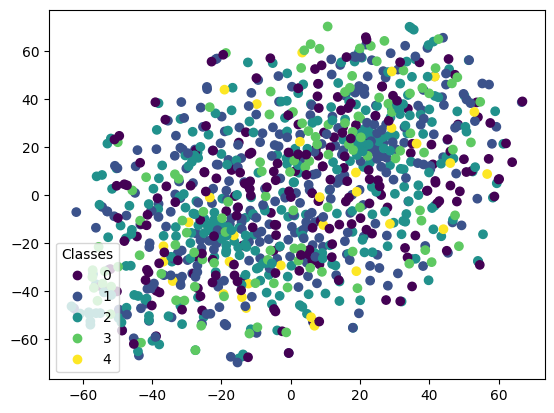

In [111]:
latent_x = []
y_all = []
for idx, (x, y) in enumerate(test_generator):   
    _, mean, logvar = model(x)
    latent_x.append(mean)
    y_all.append(np.expand_dims(y, axis=-1))
    if idx >= 100: break

latent_x = np.vstack(latent_x)
y_all = np.vstack(y_all)

draw_tsne_scatter(latent_x[:1000], y_all[:1000])

In [112]:
class Sampling(tf.keras.layers.Layer):
    """
    Create a sampling layer.
    Uses (mu, log_var) to sample latent vector 'z'.
    """
    def call(self, mu, log_var):
    # def call(self, inputs):
        # z_mean, z_log_var = inputs

        # Get batch size-
        batch = tf.shape(mu)[0]

        # Get latent space dimensionality-
        dim = tf.shape(mu)[1]

        # Add stochasticity by sampling from a multivariate standard 
        # Gaussian distribution-
        epsilon = tf.keras.backend.random_normal(
            shape = (batch, dim), mean = 0.0,
            stddev = 1.0
        )

        return mu + (tf.exp(0.5 * log_var) * epsilon)

In [190]:
class classifier_model(tf.keras.Model):
    def __init__(self, encoder, latent_dim = 100):
        super().__init__()
        self.latent_dim = latent_dim
        self.encoder = encoder
        self.mu = tf.keras.layers.Dense(self.latent_dim)
        self.log_var = tf.keras.layers.Dense(self.latent_dim)
        
        self.dense0 = tf.keras.layers.Dense(units = self.latent_dim)
        self.bn0 = tf.keras.layers.BatchNormalization(axis = -1)
        
        self.dense1 = tf.keras.layers.Dense(units = 500)
        self.bn1 = tf.keras.layers.BatchNormalization(axis = -1)
        
        self.dense2 = tf.keras.layers.Dense(units = 1000)
        self.bn2 = tf.keras.layers.BatchNormalization(axis = -1)
        
        self.fc = tf.keras.layers.Dense(n_classes, activation='softmax')
    
    def reparameterize(self, mu, logvar):
        # Sample from a multivariate Gaussian distribution.
        # Adds stochasticity or variation-
        eps = tf.random.normal(
            shape = mu.shape, mean = 0.0,
            stddev = 1.0
        )
        return (eps * tf.exp(logvar * 0.5) + mu)

    def call(self, x):
        x = self.encoder(x)
        
        mu = self.mu(x)
        log_var = self.log_var(x)
        z = Sampling()(mu, log_var)        
        
        #x = tf.keras.activations.relu(self.bn0(self.dense0(z)))
        #x = tf.keras.activations.relu(self.bn1(self.dense1(x)))
        #feat = self.bn2(self.dense2(x))
        
        #return self.fc(feat), feat
        return z

In [191]:
classifier = classifier_model(model.encoder, latent_dim=256)

In [192]:
classifier(x)

<tf.Tensor: shape=(64, 256), dtype=float32, numpy=
array([[ 2.25800395e-01, -6.91025972e-01, -3.52152020e-01, ...,
         1.36827254e+00, -5.25424004e-01, -1.03967357e+00],
       [-9.63809073e-01,  2.16515899e-01, -2.42162466e+00, ...,
         2.76970118e-03, -1.59063303e+00,  1.53391659e-01],
       [ 4.15930569e-01,  1.58361220e+00, -7.23006666e-01, ...,
        -2.21627250e-01,  2.40844750e+00, -8.23190451e-01],
       ...,
       [-7.27458417e-01,  3.64269078e-01,  2.21313462e-02, ...,
        -4.97355521e-01, -3.88749987e-02, -3.86968017e-01],
       [-2.35897213e-01, -9.12797987e-01,  7.00647771e-01, ...,
        -2.92585492e-01, -2.81557870e+00,  4.14307594e-01],
       [-1.05631545e-01,  3.32532525e-01, -1.68875027e+00, ...,
        -4.53907311e-01,  1.60277092e+00,  1.10753083e+00]], dtype=float32)>

In [193]:
# classifier.dense0.set_weights(model.decoder.dense0.get_weights())
# classifier.bn0.set_weights(model.decoder.bn0.get_weights())

# classifier.dense1.set_weights(model.decoder.dense1.get_weights())
# classifier.bn1.set_weights(model.decoder.bn1.get_weights())
# classifier.dense2.set_weights(model.decoder.dense2.get_weights())
# classifier.bn2.set_weights(model.decoder.bn2.get_weights())

In [187]:
classifier.encoder.trainable=False
#classifier.dense0.trainable=False
#classifier.dense1.trainable=False
#classifier.dense2.trainable=False
# classifier.bn0.trainable=False
# classifier.bn1.trainable=False
# classifier.bn2.trainable=False

In [194]:
latent_x = []
y_all = []
for idx, (x, y) in enumerate(test_generator):       
    z = classifier(x)
    latent_x.append(z)
    y_all.append(np.expand_dims(y, axis=-1))
    if idx >= 100: break

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.038s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 2.573948
[t-SNE] KL divergence after 250 iterations with early exaggeration: 125.204300
[t-SNE] KL divergence after 1000 iterations: 3.208174


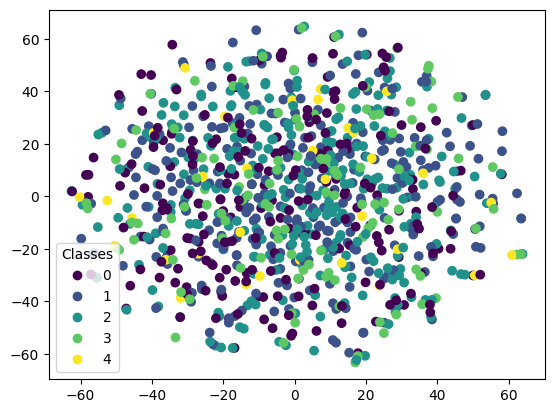

In [195]:
latent_x = np.vstack(latent_x)
y_all = np.vstack(y_all)

draw_tsne_scatter(latent_x[:1000], y_all[:1000])

In [121]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
@tf.function
def train_classifier_step(x, y):
    with tf.GradientTape() as tape:
        y_pred, _ = classifier(x, training=True)
        loss_value = loss_fn(y, y_pred)
    grads = tape.gradient(loss_value, classifier.trainable_weights)
    optimizer.apply_gradients(zip(grads, classifier.trainable_weights))    
    return loss_value, y_pred

@tf.function
def test_classifier_step(x, y):
    y_pred, _ = classifier(x, training=False)
    return y_pred

In [125]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
ckpt2 = tf.train.Checkpoint(step=tf.Variable(0), optimizer=optimizer, net=classifier)
manager2 = tf.train.CheckpointManager(ckpt2, '.tf_ckpt/ckpt_' + classifier.name, max_to_keep=1)
LOG_FOUT = open(os.path.join(LOG_DIR, 'vae_' + classifier.name + '_' + log_fname + '.txt'), 'a')
start_epoch = 0
best_test_acc = 0

In [126]:
for e in range(start_epoch, 50):    
#     correct, total_cnt, total_loss = 0.0, 0.0, 0.0
#     log_string('-'*20 + 'Epoch ' + str(e) + '-'*20)
#     adjust_learning_rate(optimizer, e)
#     start = time.time()
#     for idx, (x, y) in enumerate(train_generator):           
#         loss, y_pred = train_classifier_step(x, y)

#         total_cnt += y_pred.shape[0]
#         y_pred_cls = tf.math.argmax(y_pred, axis=-1)
#         correct += tf.reduce_sum(tf.cast(tf.equal(y_pred_cls, y), tf.float32))
#         total_loss += loss * y_pred.shape[0]
#         if (idx + 1) % 10 == 0 or idx+1 == len(train_generator):
#             print("[%d / %d] Training loss: %.6f, Training acc: %.3f"%
#                   (idx+1, len(train_generator), total_loss / total_cnt, correct / total_cnt),end='\r', flush=True)
    
#     print("")
#     log_string("Training loss: %.6f, Training acc: %.3f"%(total_loss / total_cnt, correct / total_cnt))
#     log_string("Training time: %.2f sec "%(time.time() - start))
    
    
    if (e+1 >= 10 and (e+1) % 5 == 0) or e == 0:    
        start = time.time()
        
        correct, total_cnt, total_loss = 0.0, 0.0, 0.0
        for idx, (x, y) in enumerate(test_generator):            
            y_pred = test_classifier_step(x, y)
            y_pred_cls = tf.math.argmax(y_pred, axis=-1)
            correct += tf.reduce_sum(tf.cast(tf.equal(y_pred_cls, y), tf.float32))
            total_cnt += y_pred.shape[0]
            y = tf.cast(y, dtype=tf.int32)
            y_onehot = tf.one_hot(y, depth=n_classes)
            total_loss += loss_fn(y, y_pred).numpy() * y_pred.shape[0]            
                
            test_acc = correct / total_cnt
            test_loss = total_loss / total_cnt
            if (idx + 1) % 10 == 0 or idx+1 == len(test_generator):
                print("[%d / %d] test loss: %.6f, test accuracy: %.3f"%
                    (idx+1, len(test_generator), test_loss, test_acc),end='\r', flush=True)
            
        print("")
        log_string("test loss: %.6f, test acc: %.3f"%(test_loss, test_acc))
        log_string("Eval time: %.2f sec"%(time.time() - start))
        
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            save_path = manager2.save(checkpoint_number=ckpt2.step)
            print("Saved checkpoint for step {}: {}".format(int(ckpt2.step), save_path))   

    ckpt.step.assign_add(1)
    break

LOG_FOUT.close()

[3071 / 3071] test loss: 1.213422, test accuracy: 0.503
test loss: 1.213422, test acc: 0.503
Eval time: 240.18 sec
Saved checkpoint for step 0: .tf_ckpt/ckpt_classifier_model_2/ckpt-0


In [179]:
x, y = next(iter(train_generator))

In [180]:
x.shape

(64, 6000, 1)

In [181]:
x_recon, mu, log_var = model(x)

In [182]:
import matplotlib.pyplot as plt

In [184]:
y

array([2, 2, 2, 3, 4, 0, 2, 4, 3, 3, 3, 3, 1, 1, 0, 3, 3, 2, 0, 3, 3, 4,
       1, 0, 0, 0, 0, 2, 3, 2, 4, 0, 0, 1, 3, 4, 2, 3, 3, 1, 4, 4, 3, 0,
       0, 4, 3, 1, 2, 2, 4, 0, 2, 3, 0, 2, 0, 2, 3, 0, 2, 3, 4, 2],
      dtype=int32)

1


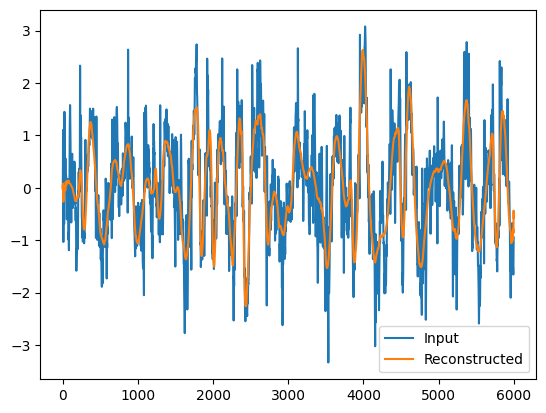

In [185]:
idx = 12
print(y[idx])
plt.plot(x[idx], label='Input')
plt.plot(x_recon[idx],label='Reconstructed')
plt.legend()
plt.show()

In [40]:
plt.plot(x_recon[0])

In [41]:
tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)(x, x_recon)

<tf.Tensor: shape=(64, 6000), dtype=float32, numpy=
array([[1.16358222e-02, 1.17597930e-01, 2.96794623e-01, ...,
        3.42104405e-01, 1.29380059e+00, 2.33858132e+00],
       [6.87937960e-02, 1.58158597e-03, 6.70730835e-04, ...,
        5.30069247e-02, 2.96855601e-03, 1.13550246e-01],
       [5.85987680e-02, 1.77194420e-02, 1.78997397e-01, ...,
        8.82604439e-03, 5.25498576e-02, 2.08115175e-01],
       ...,
       [3.98309268e-02, 3.89508791e-02, 8.98441672e-02, ...,
        9.43838954e-02, 5.27337432e-01, 1.15803969e+00],
       [2.25149393e-02, 8.58443826e-02, 3.15162450e-01, ...,
        1.56732786e+00, 1.20512271e+00, 1.07895386e+00],
       [1.36350794e-02, 9.73501951e-02, 1.30841568e-01, ...,
        9.16267097e-01, 5.11099756e-01, 1.77020147e-01]], dtype=float32)>

In [42]:
tf.reduce_mean(tf.reduce_sum((x - x_recon) ** 2,axis=1)) / 64

<tf.Tensor: shape=(), dtype=float32, numpy=26.635237>